# Rock, Paper & Scissors with TensorFlow Hub - TFLite

## Setup

In [1]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the rock, paper and scissors dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"rock_paper_scissors"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [4]:
(train_examples, validation_examples, test_examples), info = tfds.load(
    'rock_paper_scissors',
    split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, 
    as_supervised=True, 
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteUN1X5G/rock_paper_scissors-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteUN1X5G/rock_paper_scissors-test.tfrecord
Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [5]:
num_classes

3

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [6]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label


Now shuffle and batch the data


In [7]:
BATCH_SIZE = 32 

In [8]:
# Prepare the examples by preprocessing them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [42]:
do_fine_tuning = False

In [49]:
# Build the model with a TFHub KerasLayer and attach a classification head to it
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ), 
                   output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dense(num_classes, activation= 'softmax')
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


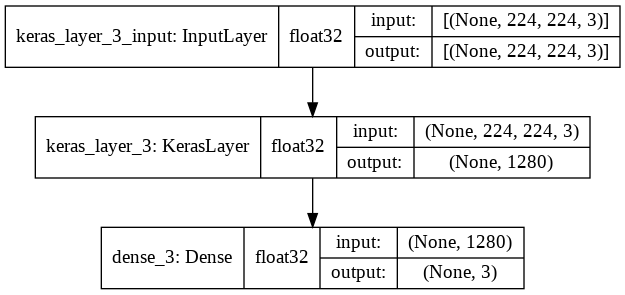

In [50]:
tf.keras.utils.plot_model(model, 'multilayer_model.png', show_shapes=True, show_dtype=True, show_layer_names=True)

## Training the model

In [51]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [52]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16/16 [==============================] - 24s 1s/step - loss: 0.9202 - accuracy: 0.5873 - val_loss: 0.4826 - val_accuracy: 0.9246
Epoch 2/5
16/16 [==============================] - 20s 1s/step - loss: 0.3464 - accuracy: 0.9444 - val_loss: 0.2311 - val_accuracy: 0.9762
Epoch 3/5
16/16 [==============================] - 21s 1s/step - loss: 0.1834 - accuracy: 0.9802 - val_loss: 0.1425 - val_accuracy: 0.9841
Epoch 4/5
16/16 [==============================] - 21s 1s/step - loss: 0.1258 - accuracy: 0.9861 - val_loss: 0.1104 - val_accuracy: 0.9921
Epoch 5/5
16/16 [==============================] - 21s 1s/step - loss: 0.1033 - accuracy: 0.9861 - val_loss: 0.0864 - val_accuracy: 0.9881


In [53]:
model.predict_proba(validation_batches)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[1.03961602e-02, 3.34361270e-02, 9.56167638e-01],
       [1.32315829e-02, 8.14135447e-02, 9.05354857e-01],
       [5.19773781e-01, 4.64604735e-01, 1.56214377e-02],
       [9.89021003e-01, 6.77828677e-03, 4.20068204e-03],
       [9.86806810e-01, 4.83208755e-03, 8.36111419e-03],
       [9.60219502e-01, 9.23781004e-03, 3.05426735e-02],
       [3.58928577e-03, 9.93642807e-01, 2.76789092e-03],
       [9.81260929e-03, 5.38550271e-03, 9.84801829e-01],
       [1.68760434e-01, 7.09093273e-01, 1.22146294e-01],
       [6.11000508e-03, 4.01535025e-03, 9.89874721e-01],
       [2.08179597e-02, 9.53641474e-01, 2.55405381e-02],
       [9.19425786e-01, 3.05422372e-03, 7.75200278e-02],
       [9.82454598e-01, 6.82752859e-03, 1.07179154e-02],
       [9.11069475e-03, 3.45675126e-02, 9.56321776e-01],
       [6.75312243e-03, 2.42390800e-02, 9.69007730e-01],
       [9.90351021e-01, 9.53438226e-03, 1.14682720e-04],
       [9.83160913e-01, 4.54680715e-03, 1.22923125e-02],
       [7.99787603e-03, 9.54960

## Export the model

In [54]:
RPS_SAVED_MODEL = "/content/saved_model"

Export the SavedModel

In [55]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/saved_model/assets


INFO:tensorflow:Assets written to: /content/saved_model/assets


Here you can verify the default signature of your exported SavedModel

In [56]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [57]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_3_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_3_input')})
{'dense_3': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense_3')}


## Convert with TFLiteConverter

In [58]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Use the tool to finally convert the model
tflite_model = converter.convert()
    
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

Run the following cells to check whether your TFLite model is working using the Python Interpreter

In [59]:
# Load TFLite model and allocate tensors.
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [60]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


In [61]:
predictions

[array([[0.17681108, 0.64216894, 0.18101993]], dtype=float32),
 array([[0.9758995 , 0.01389091, 0.01020959]], dtype=float32),
 array([[0.00835026, 0.98529184, 0.00635784]], dtype=float32),
 array([[0.05224732, 0.60736096, 0.34039184]], dtype=float32),
 array([[0.01215324, 0.06101513, 0.9268316 ]], dtype=float32),
 array([[0.00948435, 0.02014831, 0.9703673 ]], dtype=float32),
 array([[0.02882159, 0.00531832, 0.9658601 ]], dtype=float32),
 array([[0.00264921, 0.01832136, 0.9790294 ]], dtype=float32),
 array([[0.01150736, 0.05136007, 0.93713254]], dtype=float32),
 array([[0.9665254 , 0.02366611, 0.00980856]], dtype=float32)]

In [62]:

# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


In [1]:
index = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

NameError: ignored

Download the model

**NOTE: You might have to run to the cell below twice**

In [68]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))


try:
  from google.colab import files
  files.download('converted_model.tflite')  
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq rps_test_images.zip -r test_images/

In [ ]:
try:
  files.download('rps_test_images.zip')
except:
  pass